In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from shapely.geometry import Point, shape
import geopandas as gpd
from spatialdata_io import visium
from spatialdata_io import visium_hd
import pandas as pd
import spatialdata as sd
from pathlib import Path

In [2]:
sdata = visium_hd('/home/user/Documents/KODAMA/VisiumHD-CRC/Data')

/home/user/miniconda3/lib/python3.12/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/user/miniconda3/lib/python3.12/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/user/miniconda3/lib/python3.12/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [3]:
shapes = sdata.shapes["Visium_HD_Human_Colon_Cancer_square_008um"]

In [4]:
points_df = pd.DataFrame(shapes.geometry.apply(lambda geom: geom.coords[0]).tolist(), columns=['x', 'y'])
# Load the GeoJSON file
geojson_path = r'/home/user/Desktop/Visium_HD_Human_Colon_Cancer_tissue_image.ome.tiff - 20x_BF_01.geojson'  # Replace with your actual path to the GeoJSON file
geojson_data = gpd.read_file(geojson_path)
mask_geometry = geojson_data.unary_union  # Assuming the mask is a single unified geometry

/tmp/ipykernel_84817/1795863629.py:5: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  mask_geometry = geojson_data.unary_union  # Assuming the mask is a single unified geometry


Number of spots within the mask: 380266
                   x             y
0       50098.445998  13700.157336
1       49309.780167   7118.678456
3       48775.953916  18736.554443
4       56952.853796  21066.834141
6       52775.069798   7806.721445
...              ...           ...
545905  56027.954958   6915.081697
545906  59344.661303  16861.521629
545908  52999.305514  15170.099858
545909  63913.248435  11458.705512
545911  54673.240558  12241.908095

[380266 rows x 2 columns]


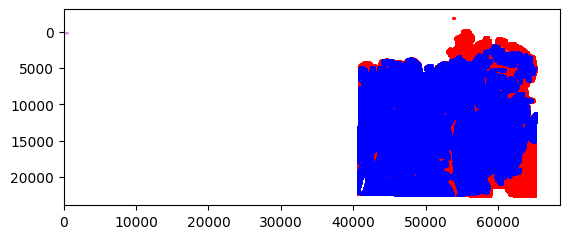

In [5]:
# Determine which spots are within the mask
points_within_mask = points_df.apply(lambda row: mask_geometry.contains(Point(row['x'], row['y'])), axis=1)
spots_in_mask = points_df[points_within_mask]

print(f"Number of spots within the mask: {spots_in_mask.shape[0]}")
print(spots_in_mask)

# Load the low-resolution image
lowres_image = sdata.images["Visium_HD_Human_Colon_Cancer_lowres_image"]
image = lowres_image.values.transpose((1, 2, 0))
x_min, y_min, x_max, y_max = shapes.total_bounds

# Plot the image and overlay the points and mask
fig, ax = plt.subplots()
ax.imshow(image)

# Plot the spots
ax.scatter(points_df['x'], points_df['y'], c='red', s=1, label='All Spots')
ax.scatter(spots_in_mask['x'], spots_in_mask['y'], c='blue', s=1, label='Spots in Mask')

## Plot the mask (GeoJSON geometry)
#for geom in geojson_data.geometry:
#    if geom.geom_type == 'Polygon':
#        x, y = geom.exterior.xy
#        ax.plot(x, y, color='green', linewidth=1, label='Mask')
#    elif geom.geom_type == 'MultiPolygon':
#        for poly in geom:
#            x, y = poly.exterior.xy
#            ax.plot(x, y, color='green', linewidth=1, label='Mask')

#plt.legend()
#plt.show()

In [6]:
points_df = shapes[['geometry']].copy()
points_df['x'] = points_df.geometry.apply(lambda p: p.x)
points_df['y'] = points_df.geometry.apply(lambda p: p.y)
points_df['spot_id'] = points_df.index

In [7]:
# Determine which spots are within the mask
points_within_mask = points_df.apply(lambda row: mask_geometry.contains(Point(row['x'], row['y'])), axis=1)
spots_in_mask = points_df[points_within_mask]

In [8]:
# Load the gene expression data
expression_data = sdata.tables["square_008um"]

In [9]:
# Map the spot indices in mask to gene expression data
spot_indices_in_mask = spots_in_mask.index
expression_data_in_mask = expression_data[spot_indices_in_mask, :]

# Create DataFrame for gene expression data
expression_df = pd.DataFrame(expression_data_in_mask.X.toarray(), index=expression_data_in_mask.obs_names, columns=expression_data_in_mask.var_names)

# Add sequences (barcodes) to spots_in_mask
spots_in_mask.loc[:, 'sequence'] = expression_data.obs_names[spot_indices_in_mask]

# Extract classifications from GeoJSON data
classifications = geojson_data[['geometry', 'classification']]  # Assuming 'classification' is the relevant field

# Merge classifications with spots data
spots_in_mask_gdf = gpd.GeoDataFrame(spots_in_mask, geometry=gpd.points_from_xy(spots_in_mask.x, spots_in_mask.y))

# Ensure there are no conflicting column names before the join
spots_in_mask_gdf = spots_in_mask_gdf.rename(columns={'spot_id': 'spot_id_left'})
classifications = classifications.rename(columns={'spot_id': 'spot_id_right'})

# Perform spatial join
spots_with_classification = gpd.sjoin(spots_in_mask_gdf, classifications, how="inner", predicate='intersects')

# Select relevant columns and rename spot_id to sequence
spots_with_classification = spots_with_classification[['sequence', 'classification']]

/home/user/miniconda3/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/tmp/ipykernel_84817/2950633244.py:22: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  spots_with_classification = gpd.sjoin(spots_in_mask_gdf, classifications, how="inner", predicate='intersects')


In [10]:
# Save to CSV
output_csv_path = r'/home/user/Desktop/spots_classification_ALL.csv'  # Replace with your desired output path
spots_with_classification.to_csv(output_csv_path, index=False)